In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d
import colorsys
from tqdm import trange, tqdm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

## Load GPR data


In [2]:
datasets = loadmat('GP_model_z.mat')

In [3]:
X_tr = datasets['X_tr'][:,0:80]
Y_tr_z = datasets['Y_tr_z']

In [4]:
kernel_0 = RBF(datasets['gp_opt_params'][0,0], (1e0, 1e2)) + WhiteKernel(datasets['gp_opt_params'][0,1], (5e-4,5e-3))
gp_opt_0 = GaussianProcessRegressor(kernel=kernel_0, n_restarts_optimizer=0, optimizer = None)
gp_opt_0.fit(X_tr, Y_tr_z[0])
# gp_opt_0.optimizer = None
# gp_opt_0.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][0])

print('LML_0 done')

kernel_1 = RBF(datasets['gp_opt_params'][1,0], (1e0, 1e1)) + WhiteKernel(datasets['gp_opt_params'][1,1], (1e-3,1e-1))
gp_opt_1 = GaussianProcessRegressor(kernel=kernel_1, n_restarts_optimizer=0, optimizer = None)
gp_opt_1.fit(X_tr,Y_tr_z[1])
# gp_opt_1.optimizer = None
# gp_opt_1.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][1])

print('LML_1 done')

kernel_2 = RBF(datasets['gp_opt_params'][2,0], (1e-4, 1e2)) + WhiteKernel(datasets['gp_opt_params'][2,1], (1e-3,1e-2))
gp_opt_2 = GaussianProcessRegressor(kernel=kernel_2, n_restarts_optimizer=0, optimizer = None)
gp_opt_2.fit(X_tr, Y_tr_z[2])
# gp_opt_2.optimizer = None
# gp_opt_2.fit(datasets_all['X_tr'], datasets_all['Y_tr_z'][2])

print('LML_2 done')

LML_0 done
LML_1 done
LML_2 done


## Load experimental data

In [5]:
import os
data_path = './Data/L62_Temp/'
filename_list = os.listdir(data_path)
data_list = []
for filename in filename_list:
    data = np.loadtxt(data_path + filename, skiprows=1, delimiter='\t')
    data_list.append(data)

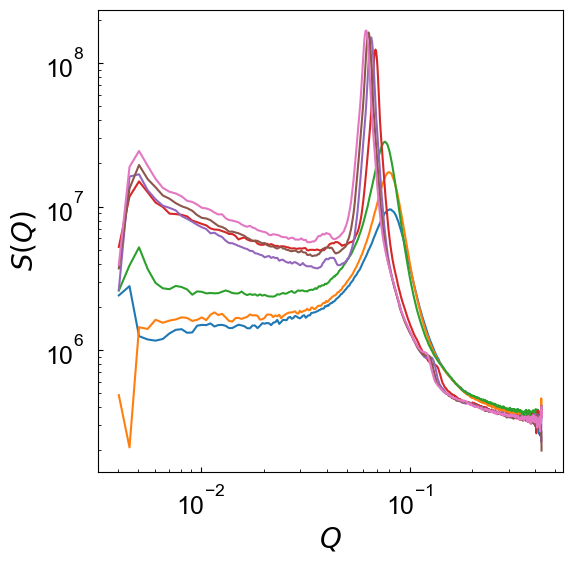

In [6]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
for data in data_list:
    Q = data[:,0]
    IQ = data[:,1]
    IQ_err = data[:,2]
    ax.plot(Q, IQ, label=data[0])

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$S(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

### Trim the data

0.0802776
0.0797727
0.0762385
0.0686651
0.0651309
0.0636162
0.0621015


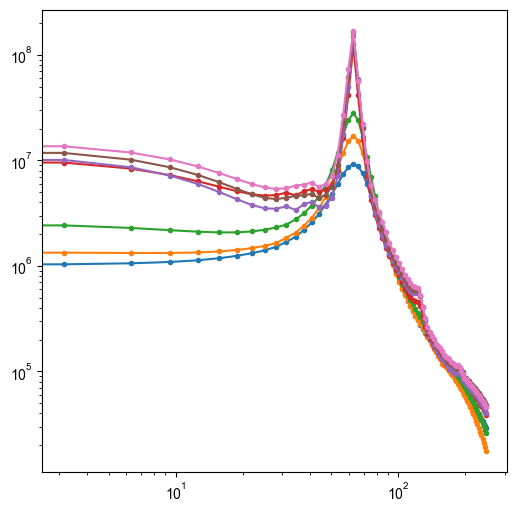

In [7]:
from scipy import interpolate
IQ_list = []
qq = datasets['qq']

## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for data in data_list:
    Q_in = data[:,0]
    IQ_in = data[:,1]
    IQ_err_in = data[:,2]

    ## trim low Q
    index_Q = Q_in>7e-3
    Q = Q_in[index_Q]
    IQ = IQ_in[index_Q]
    IQ_err = IQ_err_in[index_Q]

    ## extend low Q
    index_low_Q = Q<3.5e-2
    Q_low_Q = Q[index_low_Q]
    IQ_low_Q = IQ[index_low_Q]
    coeff = np.polyfit(Q_low_Q, IQ_low_Q, 2)
    p = np.poly1d(coeff)
    IQ[index_low_Q] = p(Q_low_Q)

    ## substrate background
    index_high_Q = Q>3.5e-1
    IQ_high_Q = IQ[index_high_Q]
    I_bg = np.mean(IQ_high_Q)
    IQ = IQ - I_bg

    ## extend high Q
    index_high_Q = (Q>2e-1)
    index_high_Q_fit = (Q>2e-1)*(Q<3e-1)
    Q_high_Q = Q[index_high_Q_fit]
    IQ_high_Q = IQ[index_high_Q_fit]
    coeff = np.polyfit(Q_high_Q, np.log(IQ_high_Q), 2)
    p = np.poly1d(coeff)
    IQ[index_high_Q] = np.exp(p(Q[index_high_Q]))

    ## peak_position
    index_Q_max = np.argmax(IQ)
    Q_max = Q[index_Q_max]
    print(Q_max)
    Q_rs = Q/Q_max*np.pi*20
    f_interp = interpolate.interp1d(Q_rs, IQ, kind='linear',fill_value='extrapolate')
    IQ_interp = f_interp(qq)
    IQ_interp[IQ_interp<0] = 1e4

    IQ_list.append(IQ_interp[0])

    ax.plot(qq[qq<=250], IQ_interp[qq<=250], '.-', label=data[0])
    # ax.plot(Q_high_Q, IQ[index_high_Q], '.', label=data[0])

IQ_list = np.array(IQ_list)

ax.set_yscale('log')
ax.set_xscale('log')

In [9]:
zscore = lambda X: np.array([(x-np.mean(x))/np.std(x) for x in X])
f_F = lambda x: np.log(x)-0*np.mean(np.log(x),axis=0) # N by 80

F_exp = np.log(IQ_list)
X_exp = zscore(F_exp)[:,1:81]

In [10]:
Y_pred_0, Y_std_0 = gp_opt_0.predict(X_exp,return_std=True)
Y_pred_1, Y_std_1 = gp_opt_1.predict(X_exp,return_std=True)
Y_pred_2, Y_std_2 = gp_opt_2.predict(X_exp,return_std=True)

Y_pred_0 = Y_pred_0*datasets['Y_tr_std'][0][0] + datasets['Y_tr_mean'][0][0]
Y_pred_1 = Y_pred_1*datasets['Y_tr_std'][0][1] + datasets['Y_tr_mean'][0][1]
Y_pred_2 = Y_pred_2*datasets['Y_tr_std'][0][2] + datasets['Y_tr_mean'][0][2]
Y_std_0 = Y_std_0*datasets['Y_tr_std'][0][0]
Y_std_1 = Y_std_1*datasets['Y_tr_std'][0][1]
Y_std_2 = Y_std_2*datasets['Y_tr_std'][0][2]

In [11]:
Y_std_2

array([0.14877958, 0.1488026 , 0.14880107, 0.14815989, 0.14875867,
       0.14843649, 0.14759506])

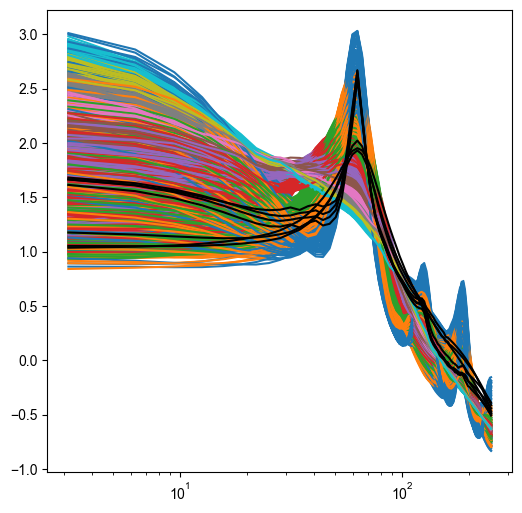

In [12]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
ax.plot(qq[0][1:81], X_tr.T)
ax.plot(qq[0][1:81], X_exp.T,'-k')

ax.set_xscale('log')

## Visualize real space model from experimental data

In [13]:
import pyvista as pv
pv.set_jupyter_backend('trame')
from PIL import Image

from randomwave import *

def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_k(k_mean,k_cov,kappa):
    k = np.random.multivariate_normal(k_mean,k_cov)
    # misorientation
    """
    https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
    https://doi.org/10.1080/03610919408813161
    """
    sigma = 1e-6 # avoid numerical instability
    xi = np.random.rand()
    W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
    phi = np.arccos(W)
    theta = np.random.rand()*2*np.pi
    axis = [np.cos(theta),np.sin(theta),0]
    R = rotation_matrix(axis,phi)
    k_sample_rot = R@k

    return k_sample_rot

def sample_wave_MO(r_grid, k_mean, k_cov, n_wave = 100, kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov,kappa)

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

In [14]:
## Meshgrid
n_grid = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid = np.meshgrid(x,y,z) 

#### Wave vector distribution ####
k_z_list = Y_pred_0
kappa_list = np.exp(Y_pred_1)
alpha_list = Y_pred_2

n_wave = 60
alpha = 0 # clipping level

i = 0
# for k_z, kappa, alpha in zip(k_z_list,kappa_list,alpha_list):
#     k_mean = np.array([0,0,20])*np.pi # lamellar perpendicular to z axis 
#     k_var  = (np.array([0,0,k_z])*np.pi)**2
#     k_cov  = np.diagflat(k_var)

#     ### Clipping random wave ####
#     rho = sample_wave_MO(r_grid,k_mean,k_cov,n_wave = n_wave,kappa = kappa)

#     # pyvista
#     # https://stackoverflow.com/questions/6030098
#     grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
#     grid["vol"] = rho.flatten('F')
#     mesh = grid.contour([alpha])

#     # Visualization
#     pv.set_plot_theme('document')
#     pl = pv.Plotter(window_size=[600, 600])
#     pl.enable_anti_aliasing('msaa')

#     backface_params = dict(color='#303030',
#                         ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
#     #                        opacity=0.5
#                         )
#     pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
#                 ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
#                 backface_params=backface_params, 
#                 smooth_shading=True, 
#     #             opacity=0.5
#                 )

#     # camera setting
#     pl.camera_position = 'yz'
#     pl.camera.azimuth = -60.0
#     pl.camera.elevation = 24.0
#     pl.camera.reset_clipping_range()

#     # light setting
#     light = pv.Light()
#     light.set_direction_angle(21, -55.0)
#     light.attenuation_values = (0,0,2)
#     pl.add_light(light)

#     filename = './Figures/exp/'+ filename_list[i] +'.png'
#     pl.show(screenshot=filename)
#     i+=1

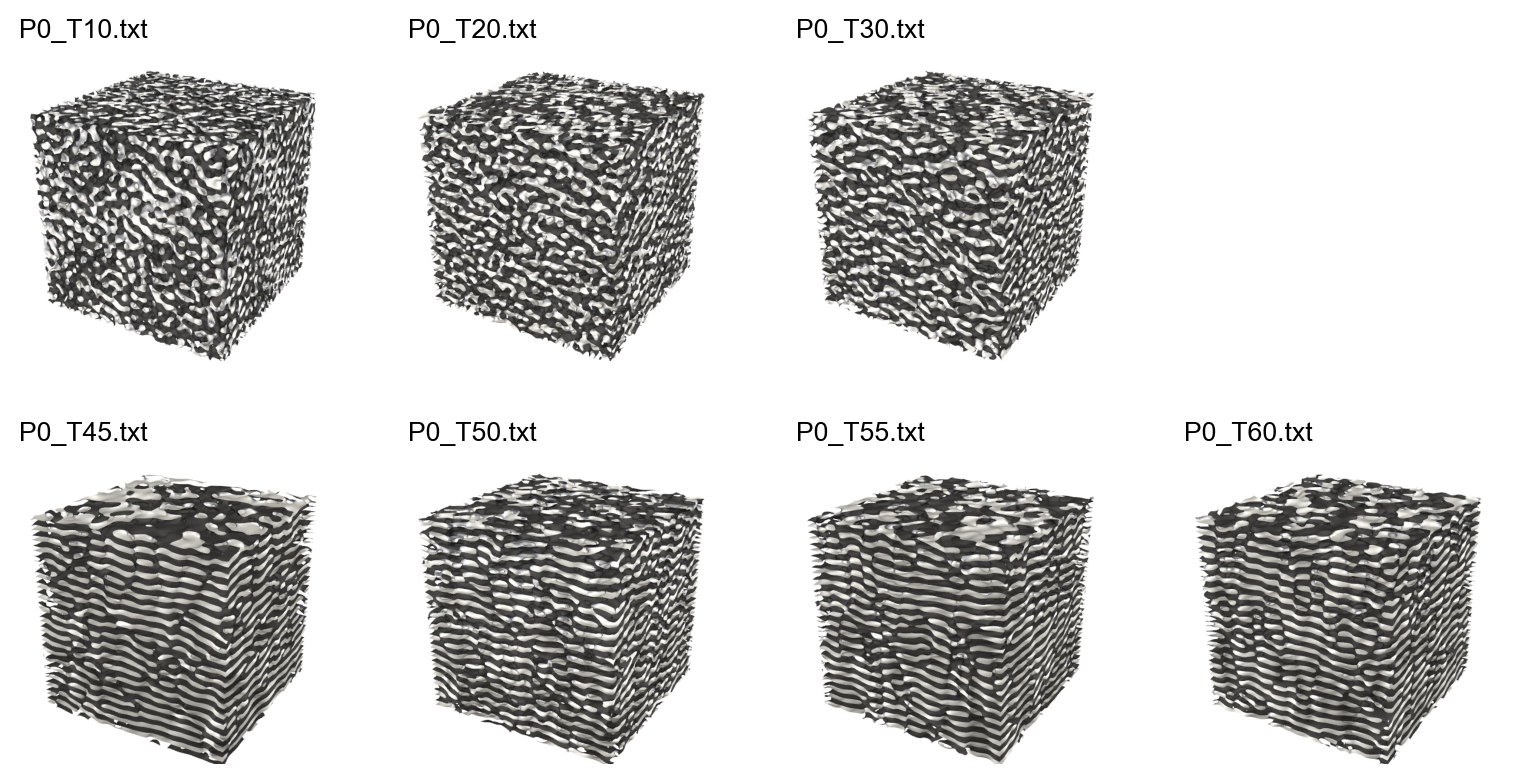

In [15]:
fig = plt.figure(figsize=(10, 5),dpi=192)
panel_position = [1,2,3,5,6,7,8]
for i, filename in enumerate(filename_list):
    ax = plt.subplot(2,4,panel_position[i])
    figname = './Figures/exp/'+ filename +'.png'
    img = np.asarray(Image.open(figname))[25:575,25:575,:]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0,0,filename)

# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [16]:
def f_k(k_z, k_x, kappa, kl=20):
    #### Wave vector distribution ####
    k_mean = np.array([0,0,kl])*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([k_x,k_x,k_z])*np.pi)**2
    k_cov  = np.diagflat(k_var)
    k_sample = sample_k(k_mean,k_cov,kappa)

    return k_sample

def pointclouds_k(k_sample_list, filename):  
    # Visualization
    pv.set_plot_theme('dark')
    pl = pv.Plotter(window_size=[600, 600])
    # pl.enable_anti_aliasing('msaa')

    scalars = np.linalg.norm(k_sample_list/2/np.pi, axis=1)

    actor = pl.add_points(k_sample_list/2/np.pi, 
                style='points_gaussian',
                scalars=scalars,
                render_points_as_spheres=True,
                point_size=2.0,
                show_scalar_bar=False,)

    # camera setting
    pl.camera_position = 'yz'
    pl.camera.azimuth = 0
    pl.camera.elevation = 0
    pl.camera.reset_clipping_range()

    def zoom_to_data(pl,bounds):
        if not pl.camera_set:
            pl.view_isometric()
        pl.reset_camera(bounds=bounds)
        pl.camera_set = True
        pl.reset_camera_clipping_range()

    zoom_to_data(pl,[-15,15, -15,15, -15,15])

    pl.show(screenshot=filename)

In [17]:
i = 0
n_sample = 10000
# for k_z, kappa, alpha in zip(k_z_list,kappa_list,alpha_list):
#     k_sample_list_0 = [f_k(k_z, 0, kappa) for i in range(n_sample)]
#     k_sample_list_1 = [-f_k(k_z, 0, kappa) for i in range(n_sample)]
#     k_sample_list = np.array(k_sample_list_0+k_sample_list_1)

#     filename = './Figures/exp/k_pointcloud'+ filename_list[i] +'.png'

#     pointclouds_k(k_sample_list, filename)
#     i+=1

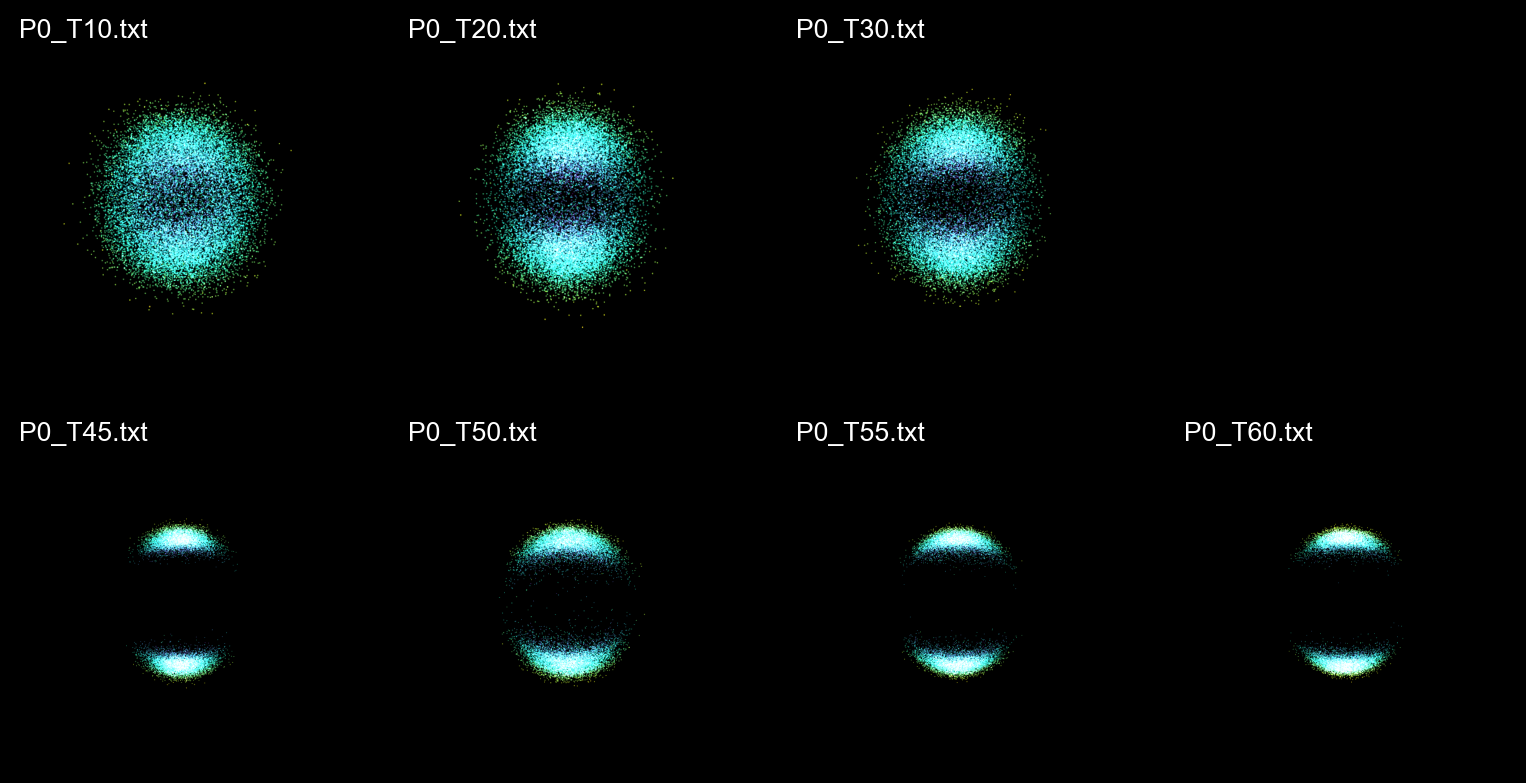

In [18]:
fig = plt.figure(figsize=(10, 5),dpi=192,facecolor='k')
panel_position = [1,2,3,5,6,7,8]
for i, filename in enumerate(filename_list):
    ax = plt.subplot(2,4,panel_position[i])
    figname = './Figures/exp/k_pointcloud'+ filename +'.png'
    img = np.asarray(Image.open(figname))[25:575,25:575,:]
    ax.imshow(img)
    ax.axis('off')
    ax.text(0,0,filename,c='w')

# plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Plot GPR results

In [19]:
k_z_list = Y_pred_0/20
kappa_list = np.exp(Y_pred_1)
alpha_list = Y_pred_2
parameters = np.array(list(zip(k_z_list, kappa_list, alpha_list)))

k_z_std_list = Y_std_0/20
kappa_std_list = Y_pred_1*Y_std_1
alpha_std_list = Y_std_2
stds = np.array(list(zip(k_z_std_list, kappa_std_list, alpha_std_list)))

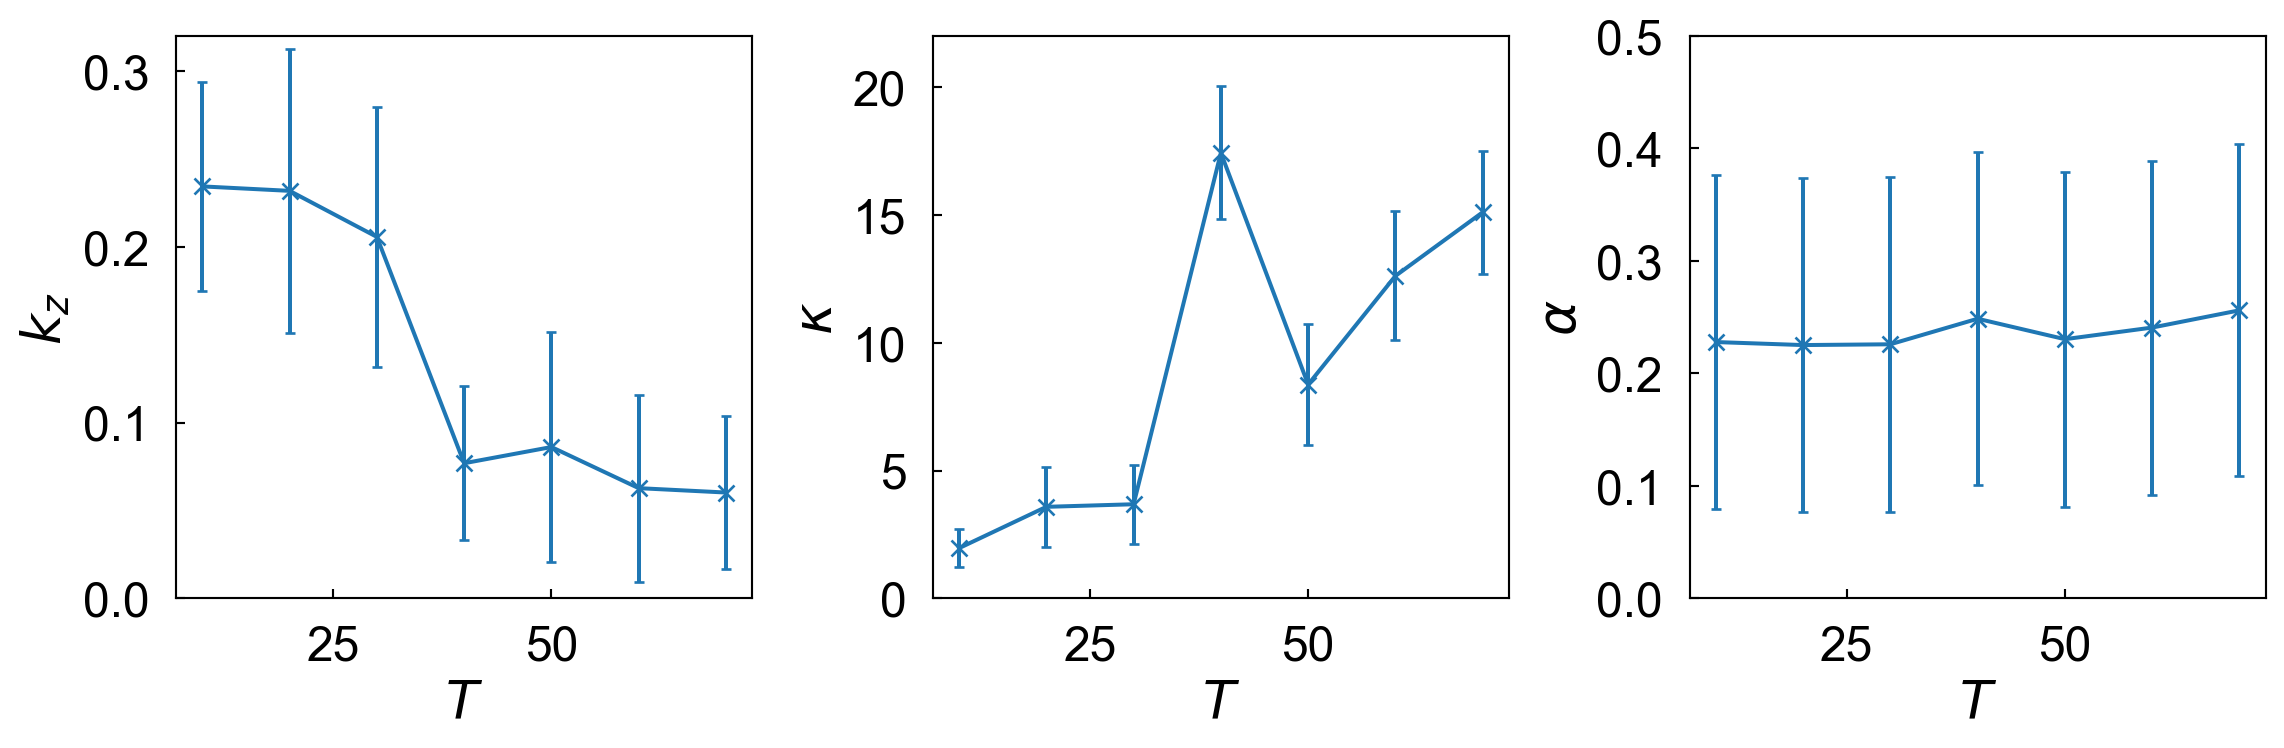

In [20]:
fig = plt.figure(figsize=(12, 4),dpi=192)
y_name = [r'$k_z$', r'$\kappa$', r'$\alpha$']
ylim = [[0,0.32],[0,22],[0,0.5]]
T = np.arange(7)*10+10
for i in range(3):
    ax = plt.subplot(1,3,i+1)
    ax.errorbar(T,parameters[:,i],stds[:,i],capsize=2,marker='x')

    ax.set_xlabel(r'$T$',fontsize=20)
    ax.set_ylabel(y_name[i],fontsize=20)
    ax.set_ylim(ylim[i])
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

plt.tight_layout()

## Reproduce I(Q)

In [21]:
from randomwave import *

In [22]:
S_q_exp = []
n_wave = 30
n_sample = 10

for k_z, kappa, alpha in zip(k_z_list,kappa_list,alpha_list):
    k_mean = np.array([0,0,20])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,k_z])*np.pi)**2
    k_cov  = np.diagflat(k_var)

    S_q_list = []

    for i in trange(n_sample):
        # create sample
        rho = sample_wave_MO(r_grid,k_mean,k_cov,n_wave = n_wave,kappa = kappa)

        # calculate scattering function
        box_size = 2
        n_grid_scale = 256
        scale = n_grid_scale/rho.shape[0]
        dq = 2*np.pi/box_size
        qq = np.arange(n_grid_scale/2)*dq

        S_q_i = scatter_grid(rho,alpha,qq,scale=scale)
        S_q_list.append(S_q_i)

    S_q = np.mean(np.array(S_q_list),axis=0)
    S_q_exp.append(S_q)

100%|██████████| 10/10 [01:31<00:00,  9.16s/it]


In [27]:
S_q_exp = np.array(S_q_exp)
filename = 'SQ_exp.mat'
mdic = {'S_q_exp': S_q_exp}
savemat(filename, mdic)

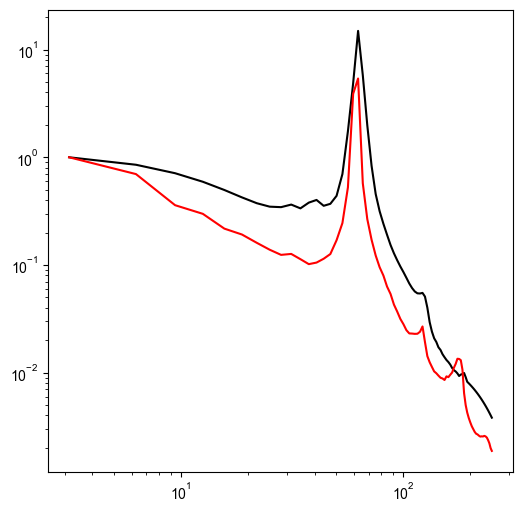

In [46]:
## plot reconstructed IQ
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

for i, IQ in enumerate(IQ_list):
    if i == 4:
        ax.plot(qq[1:81], IQ[1:81]/IQ[1],'k')
        ax.plot(qq[1:81], S_q_exp[i,1:81]/S_q_exp[i,1],'r')
        ax.set_xscale('log')
        ax.set_yscale('log')